# Dunking Data analysis

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

## Import data

In [8]:
dunk_data = pd.read_csv('data/dunking-data.csv')
dunk_data

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob
...,...,...,...,...,...,...
2995,0.084596,1.557367,0.000981,0.003221,24.231107,Digestive
2996,0.067928,1.487239,0.000993,0.003933,12.256570,Hobnob
2997,0.059526,1.444489,0.000998,0.007583,26.464108,Hobnob
2998,0.071386,1.212213,0.001004,0.013988,22.772293,Digestive


In [10]:
digestive_dunk = dunk_data[dunk_data['biscuit'] == 'Digestive']
hobnob_dunk = dunk_data[dunk_data['biscuit'] == 'Hobnob']
rich_dunk = dunk_data[dunk_data['biscuit'] == 'Rich Tea']

## PCA analysis

In [16]:
scaled_data = scale(dunk_data.drop(['biscuit'], axis = 1))

In [22]:
pca_5 = PCA(n_components = 5)
pca_5.fit(scaled_data)

transformed_5 = pca_5.fit_transform(scaled_data)

[0.36987929 0.2063917  0.20310831 0.19161252 0.02900817]


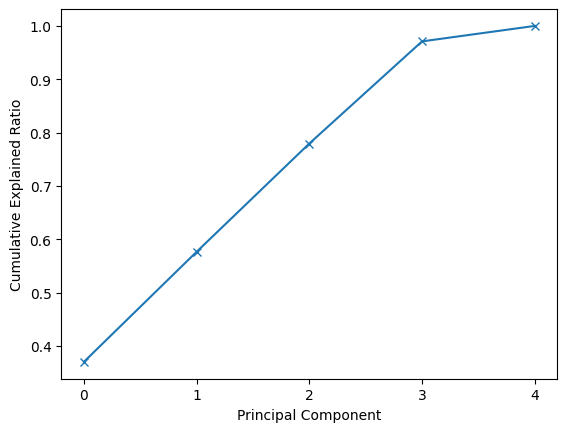

In [23]:
# See explained variances

fig,ax = plt.subplots()

print(pca_5.explained_variance_ratio_)

ax.plot(np.cumsum(pca_5.explained_variance_ratio_), marker = 'x')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Ratio')
ax.set_xticks([0,1,2,3,4])

plt.show()

In [26]:
# Define new PCA to get two largest components

pca_2 = PCA(n_components = 2)
transformed_2 = pca_2.fit_transform(scaled_data)

# Create Loading Matrix to see breakdown of two largest principal components

loading_matrix = pd.DataFrame(transformed_5[-2:].T* np.sqrt(pca_2.explained_variance_), 
                              columns=['PC1', 'PC2'], index = dunk_data.columns[:5])
loading_matrix

,PC1,PC2
gamma,4.640787,-0.876083
phi,-0.873617,0.043447
eta,-0.382649,1.208665
L,0.406842,-0.274004
t,-0.035197,0.171280


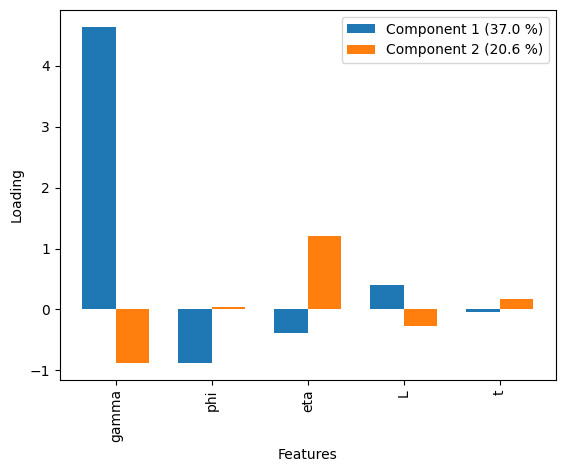

In [33]:
# Plot breakdowns of two largest principal components

ind = np.arange(len(loading_matrix.index))
width = 0.35

fig, ax = plt.subplots()
ax.bar(ind, loading_matrix['PC1'], width, 
       label='Component 1 ({:.1f} %)'.format(pca_5.explained_variance_ratio_[0] * 100))
ax.bar(ind + width, loading_matrix['PC2'], width, 
       label='Component 2 ({:.1f} %)'.format(pca_5.explained_variance_ratio_[1] * 100))
ax.set_xlabel('Features')
ax.set_ylabel('Loading')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(loading_matrix.index)
ax.tick_params(axis='x', rotation=90)
ax.legend()
plt.show()

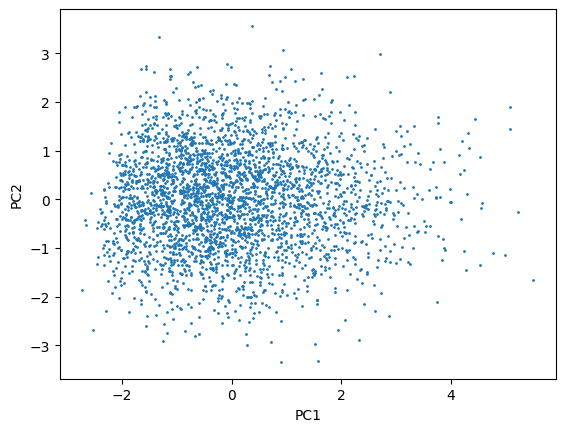

In [43]:
# Check for clustering in first two principal components

fig, ax = plt.subplots()

plt.scatter(transformed_2[:,0], transformed_2[:,1], s = 1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.show()

## Get training and test data

In [53]:
# Split test and train data

X = scaled_data
y = dunk_data['biscuit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
X_train.shape, X_test.shape

((2250, 5), (750, 5))

## Train RF and SVC classifiers

In [57]:
# Fit random forest classifier

rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [58]:
# Test classifer is 100% accurate on training data

y_pred_train_rf = rf_classifier.predict(X_train)
rf_training_accuracy = rf_classifier.score(X_train, y_train) * 100
print(f'Accuracy on training data: {rf_training_accuracy:.1f} %')

# Test classifier on test data

y_pred_rf = rf_classifier.predict(X_test)
rf_testing_accuracy = rf_classifier.score(X_test, y_test) * 100
print(f'Accuracy on testing data: {rf_testing_accuracy:.1f} %')

# Get classification data
print(classification_report(y_test, y_pred_rf))

Accuracy on training data: 100.0 %
Accuracy on testing data: 80.5 %
              precision    recall  f1-score   support

   Digestive       0.85      0.88      0.87       250
      Hobnob       0.72      0.69      0.70       250
    Rich Tea       0.83      0.84      0.84       250

    accuracy                           0.81       750
   macro avg       0.80      0.81      0.80       750
weighted avg       0.80      0.81      0.80       750



In [59]:
# Fit svc model

svc_classifier = SVC(random_state=42, gamma='auto', probability = True)
svc_classifier.fit(X_train, y_train)

SVC(gamma='auto', probability=True, random_state=42)

In [60]:
# Test svc model on test data

y_pred_train_svc = svc_classifier.predict(X_train)
svc_training_accuracy = svc_classifier.score(X_train, y_train) * 100
print(f'Accuracy on training data: {svc_training_accuracy:.1f} %')

# Test svc model on test data

y_pred_svc = svc_classifier.predict(X_test)
svc_testing_accuracy = svc_classifier.score(X_test, y_test) * 100
print(f'Accuracy on test data: {svc_testing_accuracy:.1f} %')

# Get classification data
print(classification_report(y_test, y_pred_svc))

Accuracy on training data: 88.4 %
Accuracy on test data: 86.1 %
              precision    recall  f1-score   support

   Digestive       0.94      0.89      0.91       250
      Hobnob       0.83      0.78      0.81       250
    Rich Tea       0.82      0.92      0.86       250

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750

